In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from __future__ import print_function, absolute_import, division

In [4]:
import numpy as np
from wgomoku import (
    GomokuBoard, Move, StochasticMaxSampler, HeuristicGomokuPolicy, ThreatSearch,
    Heuristics, GomokuTools as gt, 
    create_sample, create_samples_and_qvalues, data_from_game)

In [ ]:
import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available()

In [ ]:
A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U = \
    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK=0
WHITE=1
EDGES=2

In [ ]:
import pandas as pd
df = pd.read_csv("self_play_data/startwith_i10h9j9h11k10j10_style_2_ts_65.csv")
game = df['game'][5]
game

In [ ]:
stones = gt.string_to_stones(game)
stones = [(ord(x)-64, y) for x,y in stones]
print(stones)

In [ ]:
size=19
until = -1
p = HeuristicGomokuPolicy(style = 2, bias=.5, topn=5)
heuristics = Heuristics(kappa=3.0)
board = GomokuBoard(N=size, stones=stones[:until], disp_width=10, heuristics=heuristics)
board.display(probas=lambda x: p.probas(x, 2))

In [1]:
class ResNet:
    """
    After sufficient training, this instance of ResNet takes an array of dimensions 10x10 
    and returns 1 if the array contains the pattern you tought it to recognize.
    """
    def __init__(self, size, n_blocks, n_filters):
        
        self.inps = tf.placeholder(name="inp_resnet", 
                                   shape=[None, size+2, size+2, 2], dtype=tf.float32)
        self.lbls = tf.placeholder(name="lbl_resnet", 
                                   shape=[None, size+2, size+2, 1], dtype=tf.float32)

        out = self.inps

        for i in range(n_blocks):
            out = self._res_block(out, n_filters)

        self.out = tf.layers.conv2d(kernel_size=1, filters=1, inputs=out, 
                               padding='same', activation=None)

        # TODO: Just wouldn't work, minimizes until a certain point then losses go up again
        #lbls_1dim = tf.reshape(self.lbls, [-1, 21*21, 1])
        #outs_1dim = tf.reshape(self.out, [-1, 21*21, 1])
        #losses = tf.nn.softmax_cross_entropy_with_logits_v2(lbls_1dim, outs_1dim, axis=1)
        #self.loss = tf.reduce_sum(losses)
        self.loss = tf.losses.mean_squared_error(self.lbls, self.out)
        
        self.errors = tf.losses.mean_squared_error(self.lbls, self.out)
        self.accuracy=tf.reduce_sum(tf.cast(self.errors < .1, dtype=tf.int64))

        self.optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
        self.trainer = self.optimizer.minimize(self.loss)
    
    
    def _res_block(self, inp, filters, activation='relu'):
      
        out1_3 = tf.layers.conv2d(kernel_size=3, filters=filters, inputs=inp, 
                                  padding='same', activation=activation)
        out1_5 = tf.layers.conv2d(kernel_size=5, filters=filters, inputs=inp, 
                                  padding='same', activation=activation)
        out1 = tf.concat([out1_3, out1_5], axis=3)
        
        out2_3 = tf.layers.conv2d(kernel_size=3, filters=filters, inputs=out1, 
                                  padding='same', activation=activation)
        out2_5 = tf.layers.conv2d(kernel_size=5, filters=filters, inputs=out1, 
                                  padding='same', activation=activation)
        out2 = tf.concat([out2_3, out2_5], axis=3)
        
        out3_3 = tf.layers.conv2d(kernel_size=3, filters=filters, inputs=out2, 
                                  padding='same', activation=activation)
        out3_5 = tf.layers.conv2d(kernel_size=5, filters=filters, inputs=out2, 
                                  padding='same', activation=activation)
        out3 = tf.concat([out3_3, out3_5], axis=3)
        
        bn = tf.layers.batch_normalization(inputs=out3)

        skip = tf.layers.conv2d(kernel_size=1, filters=2, inputs=inp, 
                                padding='same', activation=None)
        
        return tf.concat([skip, bn], axis=3)

In [2]:
resnet = ResNet(n_blocks=10, n_filters=32, size=19)

NameError: name 'tf' is not defined

In [ ]:
sess.close()

In [3]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

NameError: name 'tf' is not defined

In [17]:
samples = create_samples_and_qvalues(board, p, heuristics)

In [18]:
board = GomokuBoard(N=size, stones=stones, disp_width=10, heuristics=heuristics)
samples = data_from_game(board, p, heuristics)

In [19]:
smp, _, _, lbl = samples

In [20]:
smp.shape, lbl.shape

((160, 21, 21, 2), (160, 21, 21, 1))

In [23]:
for i in range(1001):
    loss, acc, pred, err, _ = sess.run([resnet.loss, resnet.accuracy, resnet.out, 
                                        resnet.errors, resnet.trainer], 
                              feed_dict={resnet.inps: smp, resnet.lbls: lbl})
    if i % 100 == 0:
        print (loss)


5.622514e-05
1.0823928e-05
7.7767645e-06
5.9923027e-06
4.660333e-06
6.0402813e-06
3.2286407e-06
2.7333772e-06
2.3244324e-06
2.212157e-06
1.912161e-06


In [1]:
from wgomoku import to_matrix12
ind = 21
lbl_i = lbl[ind].reshape(21,21)[1:-1].T[1:-1].T
pred_i = pred[ind].reshape(21,21)[1:-1].T[1:-1].T
m12 = to_matrix12(smp[ind], size=21)

NameError: name 'lbl' is not defined

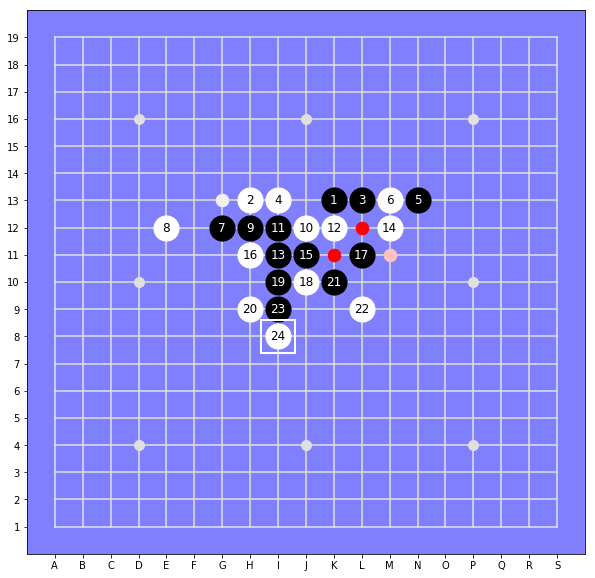

In [25]:
black = [gt.m2b(p, 19) for p, v in list(np.ndenumerate(m12)) if v == 1]
white = [gt.m2b(p, 19) for p, v in list(np.ndenumerate(m12)) if v == 2]
pairs = zip(black, white)

moves = []
for b,w in pairs: 
    moves.append(b)
    moves.append(w)
board = GomokuBoard(N=19, stones=moves, heuristics=heuristics, disp_width=10)
board.display(probas=lambda x: pred_i)

### Write to file

In [26]:
smp.shape, lbl.shape

((160, 21, 21, 2), (160, 21, 21, 1))

In [27]:
s_and_d = list(zip(smp, lbl))

In [28]:
s_and_d[0][0].shape, s_and_d[0][1].shape

((21, 21, 2), (21, 21, 1))

In [29]:
tfr_filename = "deleteme.tfr"
def _floats_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))
with tf.python_io.TFRecordWriter(tfr_filename) as writer:
    for vec in s_and_d:
        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature={
            'state': _floats_feature(vec[0].flatten()),
            'distr' : _floats_feature(vec[1].flatten()),
            }))
        writer.write(example.SerializeToString())

### Read from file

In [30]:
def _parse_function(example):
    return tf.parse_single_example(example, feature_spec)

In [31]:
dataset = tf.data.TFRecordDataset("deleteme.tfr")

In [32]:
N_p=21
feature_spec = {
    'state': tf.FixedLenFeature([N_p * N_p * 2], tf.float32),
    'distr': tf.FixedLenFeature([N_p * N_p], tf.float32)
}
decoded = dataset.map(_parse_function).make_one_shot_iterator().get_next()

In [33]:
with tf.Session() as sess:
    res2 = sess.run(decoded)

In [34]:
res2['state'].shape, res2['distr'].shape

((882,), (441,))

In [35]:
to_matrix12(res2['state'].reshape(N_p,N_p,2), size=21)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 1, 1, 1, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 1, 2, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0,